In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
import datetime as dt
from sklearn import metrics
import ipywidgets as iw

In [2]:
def SIR(data,pop,gamma,rep_num,only_new_cases = False):
    
    beta = gamma * rep_num    
    new_cases = beta * data['susceptible'] * data['cases_active'] / pop
    
    if only_new_cases:
        return new_cases
    else:
        new_recovered = gamma * data['cases_active']
        
        susceptible = data['susceptible'] - new_cases
        cases = data['cases_active'] + new_cases - new_recovered
        recovered = data['recovered'] + new_recovered
        
        return susceptible,new_cases,rep_num,cases,new_recovered,recovered
        

def get_data(population,days_to_recovery):
    gamma = 1 / days_to_recovery
    
    df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv',
                          parse_dates = ['date'],index_col = ['date']).loc[:,['cases_new','cases_active']]
    
    df['recovered_new'] = (df['cases_new'] + df['cases_active'].shift(1) - df['cases_active']).fillna(0)
    df['recovered'] = df['recovered_new'].cumsum()
    growth_rate = ((df['cases_active'] - df['cases_active'].shift(1)) / df['cases_active'].shift(1)).fillna(0)
    df.insert(1,'reproduction_number',np.maximum(0,1 + (growth_rate / gamma)))
    df.insert(0,'susceptible',population - df['recovered'])
    df['cases_new_tomorrow'] = [int(SIR(df.loc[df.index[idx]],
                                        population,gamma,
                                        df.loc[df.index[idx],'reproduction_number'],
                                        only_new_cases = True)) for idx in range(len(df.index))]
    
    #Assume tomorrow's R value is the same as today
    df['r_error'] = df['reproduction_number'].shift(1) - df['reproduction_number']
    df['case_error'] = df['cases_new_tomorrow'].shift(1) - df['cases_new']
    
    return df.loc[df.index < '2022-11-01']

def calc_rmse(data):
    return np.round(np.sqrt((data ** 2).mean()),4)


def set_sequence(size,data):
    x = []
    y = []
    
    for count in range(len(data) - size):
        window = [[s] for s in data[count : count + size]]
        label = data[count + size]
        
        x.append(window)
        y.append(label)
        
    return np.array(x),np.array(y)

In [3]:
population = 33942526
df = get_data(population,7)

df

,susceptible,cases_new,reproduction_number,cases_active,recovered_new,recovered,cases_new_tomorrow,r_error,case_error
date,,,,,,,,,
2020-01-25,33942526.0,4,1.000000,4,0.0,0.0,0,NaN,NaN
2020-01-26,33942526.0,0,1.000000,4,0.0,0.0,0,0.000000,0.0
2020-01-27,33942526.0,0,1.000000,4,0.0,0.0,0,0.000000,0.0
2020-01-28,33942526.0,0,1.000000,4,0.0,0.0,0,0.000000,0.0
2020-01-29,33942526.0,3,6.250000,7,0.0,0.0,6,-5.250000,-3.0
...,...,...,...,...,...,...,...,...,...
2022-10-27,29080809.0,2762,1.382220,28720,1275.0,4861717.0,4858,-0.268592,950.0
2022-10-28,29078848.0,3296,1.325383,30055,1961.0,4863678.0,4875,0.056837,1562.0
2022-10-29,29076306.0,3189,1.150690,30702,2542.0,4866220.0,4323,0.174693,1686.0


In [4]:
TRAIN_SPLIT = int(0.8 * len(df.index))

train = df.loc[(df.index > df.index[0]) & (df.index < df.index[TRAIN_SPLIT]),'reproduction_number'].tolist()
test = df.loc[df.index >= df.index[TRAIN_SPLIT],'reproduction_number'].tolist()

In [5]:
base_check_df = df.loc[df.index >= df.index[TRAIN_SPLIT]]

a = {calc_rmse(base_check_df['r_error']),
     calc_rmse(base_check_df['case_error'])}

a

{0.1722, 1569.3619}

In [6]:
train = df.loc[(df.index > df.index[0]) & (df.index < df.index[TRAIN_SPLIT])]
test = df.loc[df.index >= df.index[TRAIN_SPLIT]]

In [7]:
model = {}
data = {}

TRAIN_SPLIT = int(0.8 * len(df.index))


for i in range(1,21):
    df = get_data(population,i)
    
    data[i] = {}
    data[i]['base'] = df
    data[i]['error'] = {
         'train' : {'R Error' : calc_rmse(df.loc[(df.index < df.index[TRAIN_SPLIT]) 
                                                 & (df.index > df.index[0]),'r_error']),
                    'Case Error' : calc_rmse(df.loc[(df.index < df.index[TRAIN_SPLIT]) 
                                                    & (df.index > df.index[0]),'case_error'])
        },
        'test' : {'R Error' : calc_rmse(df.loc[(df.index >= df.index[TRAIN_SPLIT]),'r_error']),
                    'Case Error' : calc_rmse(df.loc[(df.index >= df.index[TRAIN_SPLIT]),'case_error'])
        },
        'overall' : {'R Error' : calc_rmse(df.loc[df.index > df.index[0],'r_error']),
                    'Case Error' : calc_rmse(df.loc[df.index > df.index[0],'case_error'])
        }
    }

In [8]:
for i in range(5,16):
    print(f'Days to Recovery: {i}')
    for label in data[i]['error'].keys():
        print(label,': ',data[i]['error'][label])
    print()

Days to Recovery: 5
train :  {'R Error': 0.7792, 'Case Error': 10827.063}
test :  {'R Error': 0.123, 'Case Error': 3394.13}
overall :  {'R Error': 0.6987, 'Case Error': 9796.9179}

Days to Recovery: 6
train :  {'R Error': 0.9274, 'Case Error': 7682.3979}
test :  {'R Error': 0.1476, 'Case Error': 2276.7537}
overall :  {'R Error': 0.8316, 'Case Error': 6942.5362}

Days to Recovery: 7
train :  {'R Error': 1.0755, 'Case Error': 5489.599}
test :  {'R Error': 0.1722, 'Case Error': 1569.3619}
overall :  {'R Error': 0.9644, 'Case Error': 4957.1906}

Days to Recovery: 8
train :  {'R Error': 1.2236, 'Case Error': 3926.0253}
test :  {'R Error': 0.1967, 'Case Error': 1186.9823}
overall :  {'R Error': 1.0973, 'Case Error': 3549.4872}

Days to Recovery: 9
train :  {'R Error': 1.3717, 'Case Error': 2841.8374}
test :  {'R Error': 0.2206, 'Case Error': 1081.0238}
overall :  {'R Error': 1.2301, 'Case Error': 2586.0617}

Days to Recovery: 10
train :  {'R Error': 1.5197, 'Case Error': 2190.2677}
test :  {

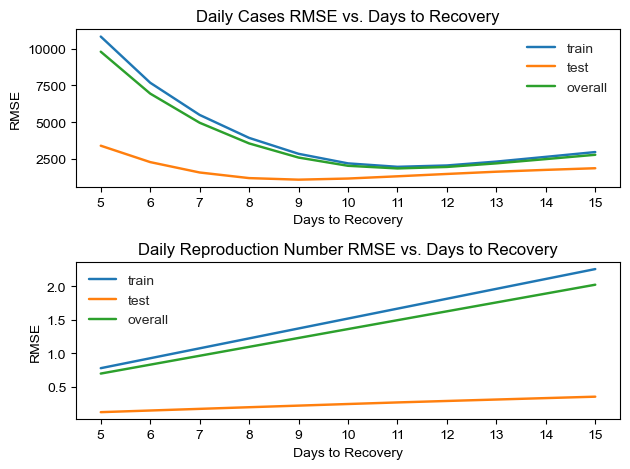

In [9]:
fig,(ax1,ax2) = plt.subplots(nrows = 2, ncols = 1)

plt.style.use('seaborn')
for label in data[9]['error'].keys():
    ax1.plot([np.nan if i < 5 else data[i]['error'][label]['Case Error'] for i in range(16)])
ax1.set_title('Daily Cases RMSE vs. Days to Recovery')
ax1.set_xlabel('Days to Recovery')
ax1.set_ylabel('RMSE')
ax1.legend(data[9]['error'].keys())
ax1.set_xticks(range(5,16))

for label in data[9]['error'].keys():
    ax2.plot([np.nan if i < 5 else data[i]['error'][label]['R Error'] for i in range(16)])
ax2.set_title('Daily Reproduction Number RMSE vs. Days to Recovery')
ax2.set_xlabel('Days to Recovery')
ax2.set_ylabel('RMSE')
ax2.legend(data[9]['error'].keys())
ax2.set_xticks(range(5,16))

fig.tight_layout()
plt.show()

In [10]:
plt.style.use('seaborn')

def calc_rmse(data):
    return np.round(np.sqrt((data ** 2).mean()),4)

@iw.interact(i = (5,15,1))
def plot_graph(i):
    fig,(ax1,ax2) = plt.subplots(ncols=1,nrows=2)
    #fig.figure(figsize = (10,3))
    ax1.set_title(f'Daily Cases - Days to Recovery: {i}, RMSE: {calc_rmse(data[i]["base"]["case_error"])}')
    ax1.plot(data[i]['base']['cases_new'])
    ax1.plot(data[i]['base']['cases_new_tomorrow'].shift(1))
    ax1.legend(['Actual','Prediction'])
    
    ax2.set_title(f'Effective Reproduction Number - Days to Recovery: {i}, RMSE: {calc_rmse(data[i]["base"]["r_error"])}')
    ax2.plot(data[i]['base']['reproduction_number'])
    ax2.plot(data[i]['base']['reproduction_number'].shift(1))
    ax2.legend(['Actual','Prediction'])
    
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='i', max=15, min=5), Output()), _dom_classes=('widget-in…

In [11]:
calc_rmse(data[i]['base']['case_error'])

2774.9905